# EEG to Image Generation
Robert Sato, Alexander Cardaras
<br>UC Santa Cruz
## Version Info
### Updated: 7/19/21
- changed everything to OHE
- add a 50k and full train set FID calculation at the end
- change the data visualization of loss (avg? idk it looks too sharp rn)

## Issues:

## General Notes

## Revisions
- added
    - class conditioned outputs
    - validation set testing/visualization

^ not tested yet

# Directions:
- **Execute** mount drive cell
- **Skip** load, convert and save data to Numpy files section
- **Execute** cells starting from **Classify the EEG wave data section**

**Mount drive**

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# Colab Pro GPUs
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul 21 20:35:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Colab Pro More RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Load, convert and save data to Numpy files
- only executed once to generate .npy files
- load the .npy files directly for future use

In [8]:
import torch
import numpy as np
from numpy import save
from numpy import load

In [9]:
# use the default data_path
# eeg_55_95_std.pth - saved
# eeg_14_70_std.pth - saved
# eeg_5_95_std.pth - saved

raw_data_path = "/content/gdrive/MyDrive/EEG2Image/eeg_55_95_std.pth"
save_data_path = "/content/gdrive/MyDrive/EEG2Image/data/"

In [10]:
# load eeg data from .pth files
loaded = torch.load(raw_data_path)
data = loaded['dataset']        
labels = loaded["labels"]
images = loaded["images"]
size = len(data)
print(size)

11965


In [11]:
# convert data tensors to np
eeg_data = []
labels = []

# crop the first 20ms and last 40ms out
time_low = 20
time_high = 460

verbose = False # set to True to print information on the data

for i in range(size):
    if verbose:
        data_i = data[i]
        print("Keys stored in each data[i] object:", data_i.keys())

        eeg_i = data[i]["eeg"]
        print("Shape of data[i][\"eeg\"]:", eeg_i.shape)
        print("Type of data[i][\"eeg\"]:", eeg_i.type)
        print()

        eeg_f = data[i]["eeg"].float() # simply converts to float
        print("Shape of data[i][\"eeg\"].float():", eeg_f.shape)
        print("Type of data[i][\"eeg\"].float():", eeg_f.type)
        print()

        eeg_t = data[i]["eeg"].float().t() # transposes the matrix
        print("Shape of data[i][\"eeg\"].float().t():", eeg_t.shape)
        print("Type of data[i][\"eeg\"].float().t():", eeg_t.type)
        print()

        image = data[i]["image"]
        print("image:", image)

        label = data[i]["label"]
        print("label:", label)

        subject = data[i]["subject"]
        print("subject:", subject)

    eeg = data[i]["eeg"].float().t()
    eeg = eeg[time_low:time_high,:] # trim the data to between 0.020s - 0.460s
    label = data[i]["label"]

    # convert from tensor to numpy
    eeg_data.append(eeg.numpy())
    labels.append(label)

eeg_data = np.asarray(eeg_data)
labels = np.asarray(labels)
print("Shape of EEG data:", eeg_data.shape)
print("Shape of labels:", labels.shape)

Shape of EEG data: (11965, 440, 128)
Shape of labels: (11965,)


### Information about the .pth file data
- 6 subjects
- 40 image classes
- 50 images per class

6 subjects * 40 classes * 50 images/class = 12,000 segments
- each image (segment) = .5 ms @ 1kHz = 500 samples during the segment
- each sample = 128 channels

each segment = 128 * 500 voltage values

In [12]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy", eeg_data)
save("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy", labels)

In [ ]:
eeg_data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy")
labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_55_95.npy")

In [ ]:
print(eeg_data.shape)

# Classify the EEG wave data
- load the data
- build a model
- train the model
- evaluate
- predict

In [1]:
import numpy as np
from numpy import save, load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

### Load the data

In [57]:
# options for data separated by frequency bands
# eeg_55_95.npy
# eeg_14_70.npy
# eeg_5_95.npy

print("Input which subset of data to use. Normalized sigmoid 55-95Hz (0), 14-70Hz (1), 55-95Hz (2), 5-95Hz (3), norm linear 55-95Hz(_)")
x = input()
x = int(x)

labels = load("/content/gdrive/MyDrive/EEG2Image/data/labels_5_95.npy")
if x == 0:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_sigmoid_55_95.npy")
    print("Finished loading sigmoid normalized 55-95Hz data")
elif x == 1:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_14_70.npy")
    print("Finished loading 14-70Hz data")
elif x == 2:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_55_95.npy")
    print("Finished loading 55-95Hz data")
elif x == 3:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_5_95.npy")
    print("Finished loading 5-95Hz data")
else:
    data = load("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_linear_55_95.npy")
    print("Finished loading linear normalized 55-95Hz data")

Input which subset of data to use. Normalized sigmoid 55-95Hz (0), 14-70Hz (1), 55-95Hz (2), 5-95Hz (3), norm linear 55-95Hz(_)
2
Finished loading 55-95Hz data


In [58]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print(labels[:100])

Data shape: (11965, 440, 128)
Labels shape: (11965,)
[10 30 29 10 30 25 18 30  3  8 11 18 28 38 37 20  3 28 23  0 38 34 20 23
 39  0 17 34 11 21 20 10 37 39  7  6 26 20  1 27 30 35 37 19  9 12 18 25
 27  4 13 34 35 25  8 29 15 12 17 38 37 27 25 32 22  2 35 14  5  8 20 31
 25 31 37  2 33  6 37 32  5 26 26 20 30 34 18 23 18  2  3 19 11 26 20 27
 27 18 39 33]


### Restrict data to < 40 classes?

In [59]:
# restrict data to first num_classes classes
def restrict_data(data, labels, num_classes=10):
    data_10 = []
    labels_10 = []

    for i in range(len(labels)):
        if labels[i] < num_classes:
            data_10.append(data[i])
            labels_10.append(labels[i])

    data_10 = np.asarray(data_10)
    labels_10 = np.asarray(labels_10)

    print("Reshaped data:", data_10.shape)
    print("Reshaped labels:", labels_10.shape)

    return data_10, labels_10

In [60]:
NUM_CLASSES = 10
data, labels = restrict_data(data, labels, num_classes=NUM_CLASSES)

Reshaped data: (3000, 440, 128)
Reshaped labels: (3000,)


In [61]:
print(labels[:100])

[3 8 3 0 0 7 6 1 9 4 8 2 5 8 2 6 5 2 3 1 5 8 6 8 6 1 7 6 5 6 2 4 7 8 3 5 3
 7 5 0 7 4 0 5 4 9 3 5 0 8 3 1 1 7 8 9 7 3 6 6 1 7 9 3 8 4 4 3 9 3 5 9 3 3
 8 7 6 4 1 1 8 8 1 9 8 1 8 7 6 6 9 1 3 3 1 3 1 1 0 9]


## Normalize the data (if not already normalized)

### Mean 0, sigmoid

In [ ]:
# transpose the data to channels on the first axis to normalize
data = data.transpose(2, 0, 1)
print("Data shape:", data.shape)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# vectorie the function so it can be applied to np arrays
sigmoid_v = np.vectorize(sigmoid)

In [ ]:
def normalize_array(data):
    # compute the average
    avg = np.average(data)
    print("Average EEG reading:", avg)
    print("data[0][0] (before shifting):", data[0][0])
    # center the data around 0 by subtracting the average
    shifted = data - avg
    print("Shape of shifted data:", shifted.shape)
    print("shifted[0][0] (after shifting):", shifted[0][0])
    # apply sigmoid function to get values in the range 0 - 1
    return sigmoid_v(shifted)

def normalize_data(data):
    # expects array of arrays as input
    for i in range(len(data)):
        print("\nNormalizing channel", i)
        data[i] = normalize_array(data[i])

In [ ]:
normalize_data(data)

In [ ]:
# check normalization
print("min:", np.amin(data))
print("max:", np.amax(data))

In [ ]:
# revert the data
data = data.transpose(1, 2, 0)
print("Data shape:", data.shape)

In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_sigmoid_55_95.npy", data)

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(data[0])

### Linear Normalization - [min, max] -> [0, 1]

In [ ]:
# transpose the data to channels on the first axis to normalize
data = data.transpose(2, 0, 1)
print("Data shape:", data.shape)

In [ ]:
def normalize_data(data):
    # expects array of arrays as input
    for i in range(len(data)):
        min = np.amin(data[i])
        data[i] -= min
        # shift all values so min is 0
        # divide by new max
        max = np.amax(data[i])
        print("\nNormalizing channel", i, "\nMax:", max)
        data[i] /= max

In [ ]:
# check normalization
print("min:", np.amin(data))
print("max:", np.amax(data))

normalize_data(data)

print("After normalization:")
print("min:", np.amin(data))
print("max:", np.amax(data))

for channel in range(len(data)):
    print("Average EEG reading for channel i:", np.average(data[channel]))

In [ ]:
# revert the data
data = data.transpose(1, 2, 0)
print("Data shape:", data.shape)

In [ ]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_norm_linear_55_95.npy", data)

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(data[0])

## EEG Classification

In [62]:
# initialize training and test data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, random_state = 10)
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

# one hot encode the labels
#y_train = to_categorical(y_train, 40)
#y_test = to_categorical(y_test, 40)

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

Shape of x_train: (2400, 440, 128)
Shape of y_train: (2400,)
Shape of x_test: (600, 440, 128)
Shape of y_test: (600,)


In [63]:
# define parameters
BATCH_SIZE = 16
EPOCHS = 100

TIMESTEPS = len(data[0])
TOTAL_INPUTS = len(data)
DATA_POINTS = TOTAL_INPUTS * TIMESTEPS 
FEATURES = len(x_train[0][0])

print('TIMESTEPS =', TIMESTEPS)
print('TOTAL_INPUTS =', TOTAL_INPUTS)
print('DATA_POINTS =', DATA_POINTS)
print('FEATURES =', FEATURES)

TIMESTEPS = 440
TOTAL_INPUTS = 3000
DATA_POINTS = 1320000
FEATURES = 128


### LSTM Model

In [ ]:
# LSTM model
# reference: https://arxiv.org/pdf/1609.00344.pdf
model = Sequential()
model.add(LSTM(128, input_shape = (TIMESTEPS, FEATURES), activity_regularizer=l2(0.001))) 
model.add(Dense(128, activation='relu'))
model.add(Dense(40, activation='softmax'))

### CNN Model
This model is from the ThoughtViz paper
https://github.com/ptirupat/ThoughtViz/blob/24a4a8a7d3a3191bb0b45b7a2ba686ac7301875a/training/models/classification.py

In [64]:
# reshape the input for CNN to (_, 128, 440)
x_train = x_train.transpose(0, 2, 1)
x_test = x_test.transpose(0, 2, 1)

In [65]:
# reshape the input for CNN to (_, 128, 440, 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [66]:
# ThoughtViz paper:
# https://github.com/ptirupat/ThoughtViz/blob/24a4a8a7d3a3191bb0b45b7a2ba686ac7301875a/training/models/classification.py
print(x_train.shape)

# define the CNN model for classification
def convolutional_encoder_model(channels, observations, num_classes):
    model = Sequential()
    #model.add(BatchNormalization(input_shape=(channels, observations, 1)))
    model.add(BatchNormalization(input_shape=(channels, observations, 1) )) # dont specify batch size
    model.add(Conv2D(32, (1, 4), activation='relu'))
    model.add(Conv2D(25, (channels, 1), activation='relu'))
    model.add(MaxPooling2D((1, 3)))
    model.add(Conv2D(50, (4, 25), activation='relu', data_format='channels_first'))
    model.add(MaxPooling2D((1, 3)))
    model.add(Conv2D(100, (50, 2), activation='relu'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    return model
model = convolutional_encoder_model(FEATURES, TIMESTEPS, num_classes=NUM_CLASSES)

(2400, 128, 440, 1)


### Model Summary, Fit and Results

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 128, 440, 1)       4         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 437, 32)      160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 437, 25)        102425    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 145, 25)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 142, 1)        5050      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 47, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 46, 100)       

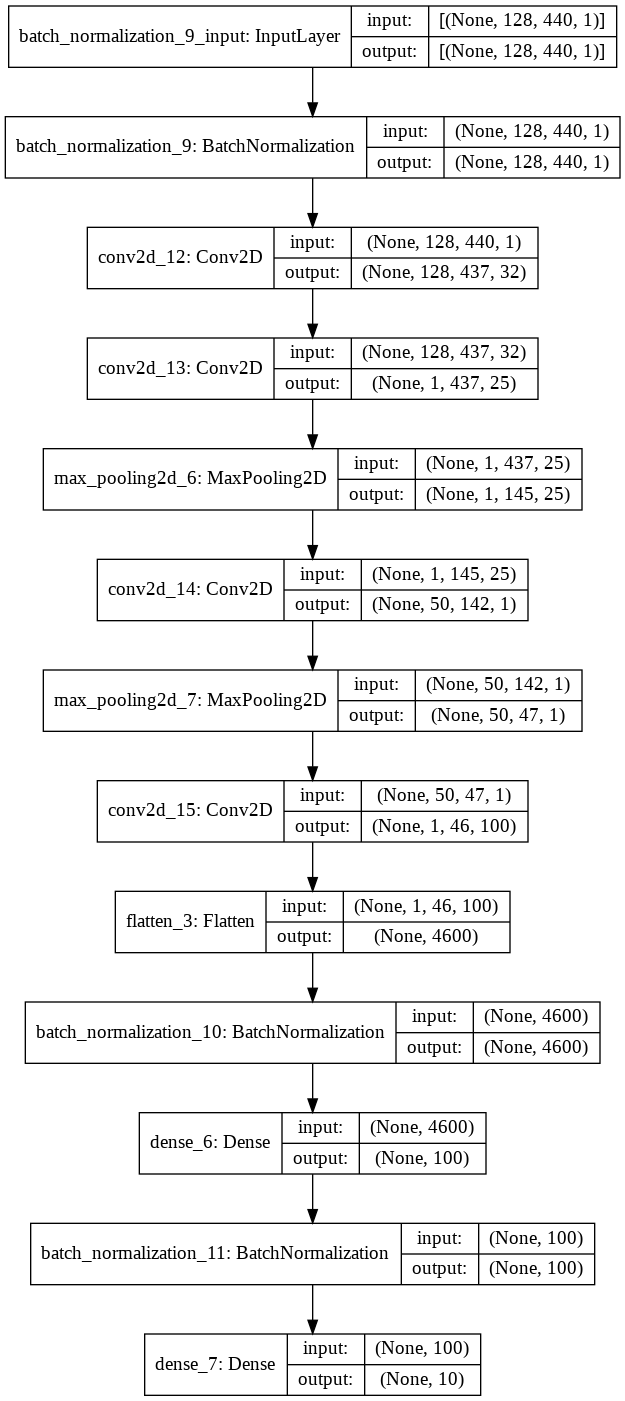

In [67]:
model.summary()
plot_model(model, to_file='classifier_model.png', show_shapes=True, show_layer_names=True)

In [68]:
# default schedule
#OPT = 'adam'
#OPT = 'SGD'
#ThoughtViz
OPT = tf.keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer = OPT, metrics = ['accuracy'])

In [69]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [70]:
history = model.fit(
    x_train, 
    y_train,
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2,
    callbacks=my_callbacks)

Epoch 1/100
135/135 - 5s - loss: 2.3087 - accuracy: 0.1944 - val_loss: 2.2990 - val_accuracy: 0.1125
Epoch 2/100
135/135 - 4s - loss: 1.7970 - accuracy: 0.3458 - val_loss: 2.2729 - val_accuracy: 0.1417
Epoch 3/100
135/135 - 4s - loss: 1.5050 - accuracy: 0.4588 - val_loss: 2.1507 - val_accuracy: 0.2167
Epoch 4/100
135/135 - 4s - loss: 1.2622 - accuracy: 0.5625 - val_loss: 1.8503 - val_accuracy: 0.3375
Epoch 5/100
135/135 - 4s - loss: 1.1057 - accuracy: 0.6264 - val_loss: 1.5293 - val_accuracy: 0.4375
Epoch 6/100
135/135 - 4s - loss: 0.9594 - accuracy: 0.6741 - val_loss: 1.4090 - val_accuracy: 0.4583
Epoch 7/100
135/135 - 4s - loss: 0.8556 - accuracy: 0.7227 - val_loss: 1.2339 - val_accuracy: 0.5250
Epoch 8/100
135/135 - 4s - loss: 0.8068 - accuracy: 0.7329 - val_loss: 1.2299 - val_accuracy: 0.5333
Epoch 9/100
135/135 - 4s - loss: 0.7032 - accuracy: 0.7769 - val_loss: 1.1463 - val_accuracy: 0.5750
Epoch 10/100
135/135 - 4s - loss: 0.6402 - accuracy: 0.8116 - val_loss: 1.1917 - val_accura

In [71]:
train_loss,train_acc = model.evaluate(x_train,y_train)
test_loss, test_acc = model.evaluate(x_test,y_test)
print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

19/19 [==============================] - 0s 13ms/step - loss: 0.7378 - accuracy: 0.7233
Training set accuracy: 0.9683333039283752
Test set accuracy: 0.7233333587646484


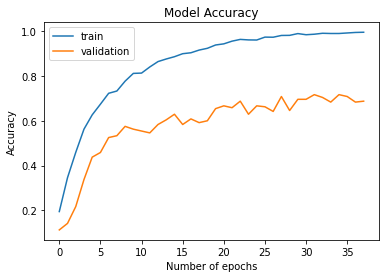

In [72]:
#plt.figure(figsize = (10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

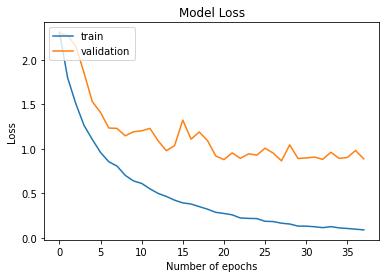

In [73]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [74]:
num_predictions = 100
correct_pred = 0
pred = np.argmax(model.predict(x_test[0:num_predictions]), axis=-1)
print_count = 0

print("Predicted class : Class label")
for i in range(num_predictions):
    label = np.argmax(y_test[i])
    #print(pred[i], "=?", label)
    print("{:2s} : {:2s}".format(str(pred[i]), str(label)), end= "     ")
    
    print_count += 1
    if print_count == 5:
        print()
        print_count = 0

    if pred[i] == label:
        correct_pred += 1

print("\nTotal correct predictions:", correct_pred)
print("Percent correct:", correct_pred/num_predictions)

Predicted class : Class label
5  : 5      0  : 0      8  : 8      4  : 5      6  : 6      
1  : 2      2  : 2      1  : 1      9  : 9      1  : 1      
4  : 4      7  : 7      7  : 7      1  : 1      2  : 2      
3  : 3      5  : 5      5  : 3      5  : 5      1  : 1      
6  : 6      8  : 8      4  : 4      0  : 0      4  : 5      
2  : 2      9  : 9      6  : 6      5  : 5      5  : 5      
6  : 6      8  : 8      0  : 0      7  : 7      8  : 3      
6  : 6      1  : 1      1  : 1      5  : 5      3  : 5      
4  : 2      1  : 1      8  : 3      6  : 6      0  : 0      
5  : 5      4  : 4      3  : 3      8  : 8      1  : 1      
7  : 9      4  : 4      2  : 2      9  : 9      3  : 8      
2  : 2      5  : 5      1  : 1      1  : 1      1  : 9      
9  : 4      8  : 8      0  : 0      4  : 5      1  : 1      
2  : 2      0  : 0      2  : 6      9  : 9      3  : 3      
1  : 1      1  : 1      6  : 9      6  : 6      3  : 3      
7  : 7      1  : 1      5  : 4      9  : 9      7  : 1 

### Create EEG feature vectors

In [79]:
# use the model to extract eeg feature vectors
# use output from an intermediate layer
def extract_features(data, model, feature_layer):
    # reshape the data for CNN
    data = data.transpose(0, 2, 1)
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)
    # use intermediate layer
    feature_extractor = tf.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(feature_layer).output)
    #features = feature_extractor(data)

    OPT = tf.keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    feature_extractor.compile(loss='categorical_crossentropy', optimizer = OPT, metrics = ['accuracy'])

    features = feature_extractor.predict(data)

    return features

In [80]:
for layer in model.layers:
    print(layer.name)

batch_normalization_9
conv2d_12
conv2d_13
max_pooling2d_6
conv2d_14
max_pooling2d_7
conv2d_15
flatten_3
batch_normalization_10
dense_6
batch_normalization_11
dense_7


In [81]:
print(data.shape)

(3000, 440, 128)


In [82]:
features = extract_features(data, model, 'dense_6') # dense layer before last
print(features.shape)
print(labels.shape)
print("Features:", features)

(3000, 100)
(3000,)
Features: [[0.0000000e+00 0.0000000e+00 4.1256505e-01 ... 7.7107851e-03
  0.0000000e+00 4.7070822e-01]
 [4.6466257e-02 1.3133524e-01 1.0083827e-01 ... 0.0000000e+00
  2.7521241e-01 1.3438022e-01]
 [0.0000000e+00 0.0000000e+00 1.8179573e-01 ... 0.0000000e+00
  2.0441605e-01 1.7053801e-01]
 ...
 [2.1410268e-04 0.0000000e+00 7.6492932e-03 ... 0.0000000e+00
  1.6134601e-02 0.0000000e+00]
 [6.1818276e-02 3.4941901e-02 5.7550468e-02 ... 0.0000000e+00
  1.7369086e-01 0.0000000e+00]
 [1.3029760e-01 0.0000000e+00 1.9268760e-01 ... 0.0000000e+00
  1.4645383e-01 2.3992676e-02]]


In [83]:
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_feature_vectors/eeg_feature_vectors_" + str(NUM_CLASSES) + "_class.npy", features)
save("/content/gdrive/MyDrive/EEG2Image/data/eeg_feature_vectors/labels_" + str(NUM_CLASSES) + "_class.npy", labels)

### Confusion matrix code reference:
https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

In [75]:
# convert from one hot to class number
Y_test = []
for y in y_test:
    Y_test.append(np.argmax(y))
y_test = np.asarray(Y_test)

# make predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [76]:
import pandas as pd
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(confusion)
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

df.style.apply(highlight_diag, axis=None)


,0,1,2,3,4,5,6,7,8,9
0,52,0,0,6,0,1,0,0,13,0
1,0,60,4,0,0,0,0,6,0,3
2,0,1,38,1,6,1,7,0,0,0
3,1,1,0,39,1,1,0,0,11,0
4,0,0,4,2,40,12,3,1,1,1
5,0,0,1,5,7,50,0,0,1,0
6,0,0,4,0,2,0,44,7,0,3
7,0,1,0,1,0,0,2,30,0,7
8,6,0,0,18,0,0,0,0,34,0
9,0,3,0,0,3,0,1,6,0,47


In [77]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.72

Micro Precision: 0.72
Micro Recall: 0.72
Micro F1-score: 0.72

Macro Precision: 0.72
Macro Recall: 0.72
Macro F1-score: 0.72

Weighted Precision: 0.74
Weighted Recall: 0.72
Weighted F1-score: 0.73


In [78]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))


Classification Report

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        72
           1       0.91      0.82      0.86        73
           2       0.75      0.70      0.72        54
           3       0.54      0.72      0.62        54
           4       0.68      0.62      0.65        64
           5       0.77      0.78      0.78        64
           6       0.77      0.73      0.75        60
           7       0.60      0.73      0.66        41
           8       0.57      0.59      0.58        58
           9       0.77      0.78      0.78        60

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.74      0.72      0.73       600



# Loading Image Net dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import tensorflow as tf

In [ ]:
def array_to_image(img):
    return img.reshape(3, 64, 64).transpose(1, 2, 0) / np.float32(255)


def save_images(image_mapping_array, label_number):
    images = image_mapping_array[label_number]

    # Loop through all images for a specific label and save them
    for index, image in enumerate(images):
        img = array_to_image(image)
        plt.imsave("images/" + str(index) + ".png", img, format="png")


def load_mapping(path, as_dict=False):
    # Load image mapping file
    label2image64 = np.load(path, allow_pickle=True)
    if as_dict:
        return label2image64[()]
    else:
        # Create a numpy ready array of image mappings [[class 0 images], [class 1 images], ... , [class 39 images]]
        return list(collections.OrderedDict(sorted(label2image64[()].items())).values())

In [ ]:
# only exec once to copy image_mapping.npy over to local
!ls /content/gdrive/MyDrive/EEG2Image/data/
!cp /content/gdrive/MyDrive/EEG2Image/data/image_mapping.npy /content/

birds_images			 eeg_norm_linear_55_95.npy   labels_14_70.npy
birds_images.npy		 eeg_norm_sigmoid_55_95.npy  labels_2_class.npy
birds_labels.npy		 image_labels.npy	     labels_55_95.npy
dataset_features.pickle		 image_mapping.npy	     labels_5_95.npy
eeg_feature_vectors_2_class.npy  images.npy


In [ ]:
def convert_data(data, image_shape=(64,64,3), scale=True):
    print("Converting data shape to 2D with 3 channels")
    if len(image_shape) != 3:
        print("Unexpected image_shape in convert_data")
        return -1
    # change the dimensions and scale
    # create new list to store the data in the correct format
    formatted_data = []
    count = 0
    for image in data:
        count += 1
        # convert from flat to 2D
        # formatted_data.append(array_to_image(image)) # that function changes bounds
        reshaped = image.reshape(3, 64, 64).transpose(1, 2, 0)
        formatted_data.append(reshaped)
    X = np.asarray(formatted_data)
    if scale:
        print("scaling values to the range [-1, 1]")
        X = X.astype('float32') # caution: storing lots of intermediate representation of image set
        X = (X - 127.5) / 127.5
    print("formatted shape:", X.shape)
    return X

In [ ]:
def augment_data(images, labels):
    augmented = []
    augmented_labels = []
    for i, image in enumerate(images):
        flipped = tf.image.flip_left_right(image)
        
        augmented.append(image)
        augmented.append(flipped)

        augmented_labels.append(labels[i])
        augmented_labels.append(labels[i])
        
    return np.asarray(augmented), np.asarray(augmented_labels)

In [ ]:
# emulate the load_data() function but only return (images, labels)
# scale flag scales the input to [-1, 1] if true
def load_image_net_data(scale=True, flip=True):
    mapping = load_mapping("image_mapping.npy", as_dict=False)
    # images stored as flat
    images = []
    num_images_per_class = 900
    for elem in mapping:
        images.append(np.asarray(elem[0:num_images_per_class])) # not all the same size so trim to 900 images per class
    images = np.asarray(images)
    num_classes = images.shape[0]
    print("shape of the data:", images.shape) # (40, 900, 12288) but want (900, 64, 64, 3)
    print("classes:", images.shape[0])
    print("images per class:", images.shape[1])
    print("pixel values in images:", images.shape[2])
    
    # append all classes into one list
    mapping = []
    for image_class in range(num_classes):
        for image in range(num_images_per_class):
            # append this image to one long new list
            mapping.append(images[image_class][image])
    mapping = np.asarray(mapping)
    print("shape after removing classes:", mapping.shape)

    data = convert_data(mapping, (64,64,3), scale)

    # create the labels
    labels = np.arange(0, 40, 1) # create labels 0 -> 39
    labels = np.repeat(labels, num_images_per_class) # repeat each label for num images per class

    if flip:
        data, labels = augment_data(data, labels)
    return data, labels

In [ ]:
printFlag = False
if printFlag:
    trainX, trainY = load_image_net_data(scale=False)
    print(trainX.shape)
    print(trainY.shape)
    print("min:", np.amin(trainX[0]))
    print("max:", np.amax(trainY[1]))
    images_per_class = 900
    print("Showing the first 10 images classes")
    plt.figure(figsize=(20, 20))
    # plot images from the training dataset
    for i in range(100):
    	# define subplot
    	plt.subplot(10, 10, 1 + i)
    	# turn off axis
    	plt.axis('off')
    	# plot raw pixel data
    	# every 10, skip rest of images in the class
    	#plt.imshow(array_to_image( trainX[i + ((i//10)*images_per_class)] ))
    	plt.imshow( trainX[i + ((i//10)*images_per_class)] )
    plt.show()

**done loading images**

# Loading CIFAR10
- create load_cifar10_data function
    - returns data, labels
    - takes parameter for scaling to [-1, 1]

In [ ]:
from tensorflow import keras
import numpy as np

In [ ]:
def load_cifar10_data(scale=True):
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    assert x_train.shape == (50000, 32, 32, 3)
    assert x_test.shape == (10000, 32, 32, 3)
    assert y_train.shape == (50000, 1)
    assert y_test.shape == (10000, 1)
    dataset = np.append(x_train, x_test, axis=0)
    labels = np.append(y_train, y_test, axis=0)
    print(dataset.shape)
    print(labels.shape)

    # scale the images to -1, 1
    if scale:
        print("scaling values to the range [-1, 1]")
        dataset = dataset.astype('float32') # caution: storing lots of intermediate representation of image set
        dataset = (dataset - 127.5) / 127.5
    return dataset, labels

# Loading Birds Dataset
Caltech-UCSD Birds 200
reference: http://www.vision.caltech.edu/visipedia/CUB-200.html

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import numpy as np
from numpy import save
from numpy import load

In [ ]:
def load_birds_data_direct(scale=True, target_shape=(64, 64)):
    path = './gdrive/MyDrive/EEG2Image/data/birds_images/images/'
    # with labels
    dataset = image_dataset_from_directory(path, 
                                           labels='inferred',
                                           label_mode='int',
                                           color_mode='rgb',
                                           batch_size=32,
                                           image_size=target_shape,
                                           shuffle=True)
    
    dataset_iterator = dataset.__iter__()
    data_list = []
    labels = []
    count = 1

    # load images from the generator into data_list and labels
    for (data, label) in dataset_iterator:
        #print('data and label shape:', data.shape, label.shape)
        data_list.extend(data)
        labels.extend(label)
        print(count, "/", dataset.__len__())
        count += 1

    # convert to numpy
    dataset = np.asarray(data_list)
    dataset = dataset.astype('int')
    labels = np.asarray(labels)

    # scaling for tanh
    if scale:
        print("scaling values to the range [-1, 1]")
        dataset = dataset.astype('float32') # caution: storing lots of intermediate representation of image set
        dataset = (dataset - 127.5) / 127.5

    return dataset, labels

In [ ]:
if False:
    images, labels = load_birds_data_direct(scale=True, target_shape=(64,64))
    print(images.shape)
    print(labels.shape)

    save("/content/gdrive/MyDrive/EEG2Image/data/birds_images.npy", images)
    save("/content/gdrive/MyDrive/EEG2Image/data/birds_labels.npy", labels)

In [ ]:
def load_birds_data():
    # already scaled: 64x64
    images_loaded = load("/content/gdrive/MyDrive/EEG2Image/data/birds_images.npy")
    labels_loaded = load("/content/gdrive/MyDrive/EEG2Image/data/birds_labels.npy")
    print('images:', images_loaded.shape)
    print('labels:', labels_loaded.shape)
    return images_loaded, labels_loaded

In [ ]:
images, labels = load_birds_data()

images: (6032, 64, 64, 3)
labels: (6032,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


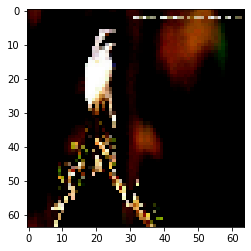

In [ ]:
plt.imshow(images[0])

# Loading Flowers dataset

In [84]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [85]:
flowers = get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [86]:
# fix resizing issue and save labels
def load_flowers_data(scale=True, target_shape=(256, 256), one_hot=False, interp='bilinear'):
    print("Loading Flowers dataset")
    print("Target Shape:", target_shape)
    img_gen = ImageDataGenerator() # stored as 0-255
    img_generator = img_gen.flow_from_directory(flowers,
                                                target_size=target_shape,
                                                class_mode='categorical',
                                                shuffle=False,
                                                interpolation=interp)

    data_list = []
    labels = []
    batch_index = 0

    # load images from the generator into data_list and labels
    while batch_index <= img_generator.batch_index:
        data, label = img_generator.next()
        data_list.extend(data)
        labels.extend(label)
        batch_index += 1

    # convert to numpy
    dataset = np.asarray(data_list)
    dataset = dataset.astype('int')
    labels = np.asarray(labels)

    # convert to integer
    if one_hot == False:
        new_labels = []
        for label in labels:
            new_labels.append(np.argmax(label))
        labels = new_labels
        labels = np.asarray(labels)

    # scaling for tanh
    if scale:
        print("scaling values to the range [-1, 1]")
        dataset = dataset.astype('float32') # caution: storing lots of intermediate representation of image set
        dataset = (dataset - 127.5) / 127.5

    return dataset, labels

In [87]:
dataset, labels = load_flowers_data(scale=False, target_shape=(64, 64))

Loading Flowers dataset
Target Shape: (64, 64)
Found 3670 images belonging to 5 classes.


(3670, 64, 64, 3)
(3670,)
7
247
2 th image:
Label: 0


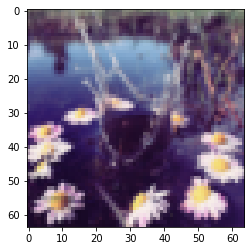

In [88]:
i = 2
print(dataset.shape)
print(labels.shape)
print(np.min(dataset[i]))
print(np.max(dataset[i]))


print(i, "th image:")
print("Label:", labels[i])
plt.imshow(dataset[i])

# Loading Flickr-Faces-HQ Dataset (FFHQ)

# Data Augmentation
- adaptive augmentation works
- augmentations not strong enough to reduce overfitting of the discriminator
- need to add more augmentation types

**issue**
- how to augment generated images when training generator? (model is already stacked = cannot access intermediate images)

In [ ]:
def augment_images(images, probability):
    #print("Augmenting...\nimage count:", len(images))
    aug_count = 0
    augmented_images = []
    for i in range(len(images)):
        #print("image", i)
        p = np.random.uniform()
        augmented = images[i]
        if p < probability: # do the rotation
            aug_count += 1
            # number of 90 deg rotations
            num_rot = np.random.randint(3) + 1
            # [0,3) + 1 = [1,4) # apply 90, 180, or 270 rotation
            #print("Rotating", num_rot, "times")
            augmented = np.rot90(augmented, num_rot)

        p = np.random.uniform()
        if p < probability: # do the x-flip 
            aug_count += 1
            #print("Flipping across x")
            augmented = np.flip(augmented)
        augmented_images.append(augmented)
    #print(aug_count,"augmentations done.")
    augmented_images = np.asarray(augmented_images)
    return augmented_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3670, 32, 32, 3)


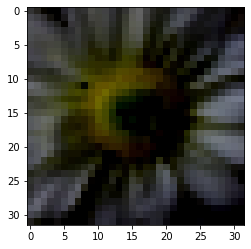

In [ ]:
print(images.shape)
plt.imshow(images[0])

p = 0.8
aug_images = augment_images(images[0:1], p)
plt.imshow(aug_images[0])

In [ ]:
# train function for nonAC GAN
def train_BASE_GAN_ADA(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    d_rs = [] # loss per batch used for averaging across epoch
    d_fs = []
    gs = []
    d_rs_epo = [] # averaged losses per epoch
    d_fs_epo = []
    gs_epo = []
    is_scores = []
    fid_scores = []

    # adaptive data augmentation
    r_t = 0
    r_target = 0.6
    ada_count = 0
    p = 0
    p_step = 1 / 50 # step size to increase/decrease p by if it is != 0.6
    N = 4
    prob_log = []
    # end ada

    # manually enumerate epochs
    for i in range(n_steps):
        if i % bat_per_epo == 0 and i > 0:
            print("\nEpoch", int(i/bat_per_epo))
            avg_loss_d_r = (sum(d_rs[:])/bat_per_epo)
            avg_loss_d_f = (sum(d_fs[:])/bat_per_epo)
            avg_loss_g = (sum(gs[:])/bat_per_epo)
            print("Average discriminator loss:", avg_loss_d_r)
            print("Average discriminator loss on fake images:", avg_loss_d_f)
            print("Average generator loss:", avg_loss_g)

            d_rs_epo.append( avg_loss_d_r ) # average disciminator loss on real samples
            d_fs_epo.append( avg_loss_d_f ) # average disciminator loss on fake samples
            gs_epo.append( avg_loss_g ) # average generator loss on real samples
            # save augmentation probability p
            prob_log.append(p)
            d_rs = []
            d_fs = []
            gs = []
            

        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # augment the real images at a probability p
        aug_real = augment_images(X_real, p)
        # update discriminator model weights using possibly augmented images
        d_r1 = d_model.train_on_batch(aug_real, y_real)

        # Adaptive Discriminator Augmentation
        # track r_t
        if ada_count == 0:
            # reset predictions
            predict_avgs = []

        # make predictions on real images
        #pred = d_model.predict(X_real) # predicting on real images when training on augmented images **possible issue**
        pred = d_model.predict(aug_real) 
        predict_avgs.append(np.average(pred))
        ada_count += 1
        
        # if count is 4, update values
        if ada_count == 4: 
            # update r_t and p every 4 batches
            ada_count = 0
            # take average of discriminator outputs every N = 4 bateches
            #print("Updating p and r_t")
            r_t = sum(predict_avgs) / len(predict_avgs)
            #print("Average prediction on", N, "batches =", r_t)

            # modify p depending on r_t
            if r_t < r_target:
                #print("r_t:", r_t, "is less than r_target:", r_target)
                #print("We are underfit so lower p =", p, "by step:", p_step, "if p>p_step")
                if p > p_step:
                    p -= p_step
            else:
                #print("r_t:", r_t, "is more than r_target:", r_target)
                #print("We are overfit so raise p =", p, "by step:", p_step, "if p<1")
                if p < 1 - p_step:
                    p += p_step
        # end ADA

        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples_BASE_GAN(g_model, latent_dim, half_batch)
        # augment the fake images at a probability p
        aug_fake = augment_images(X_fake, p)
        # update discriminator model weights
        d_f = d_model.train_on_batch(aug_fake, y_fake)

        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error

        # base GAN no AC
        g_1 = gan_model.train_on_batch(z_input, y_gan) # how to augment these images? - not augmented rn

        # summarize loss on this batch
        d_rs.append(d_r1)
        d_fs.append(d_f)
        gs.append(g_1)

        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 100) == 0:
            summarize_performance_BASE_GAN(i, g_model, latent_dim)

            # add inception scores
            score, std = get_inception_score(g_model)
            is_scores.append(score)

            # add FID scores
            fid = get_fid(g_model, latent_dim, test_image_count=1000)
            fid_scores.append(fid)
            
    d_rs_epo = np.asarray(d_rs_epo)
    d_fs_epo = np.asarray(d_fs_epo)
    gs_epo = np.asarray(gs_epo)
    is_scores = np.asarray(is_scores)
    fid_scores = np.asarray(fid_scores)
    prob_log = np.asarray(prob_log)
    return [d_rs_epo, d_fs_epo, gs_epo, is_scores, fid_scores, prob_log] 

In [ ]:
# Base GAN
print("Creating Base GAN")
# create the discriminator
discriminator = define_discriminator_JASON(lr=LR_D, beta_1=BETA_1_D, beta_2=BETA_2_D)
model_info(discriminator, "discriminator")

# create the generator
generator = define_generator_JASON(latent_dim)
model_info(generator, "generator")

# create the gan
gan_model = define_BASE_GAN(generator, discriminator, lr=LR_G, beta_1=BETA_1_G, beta_2=BETA_2_G)
model_info(gan_model, "base_GAN_model")

Creating Base GAN
Model: "JASON_discriminator_32x32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_42 (LeakyRe

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "JASON_generator_32x32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 16, 16, 1

In [ ]:
d_r_ep, d_f_ep, g_ep, is_scores, fid_scores, prob_log = train_BASE_GAN_ADA(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=10, n_batch=BATCH_SIZE)


Epoch 1
Average discriminator loss: 0.3571966956931232
Average discriminator loss on fake images: 0.4060274219029867
Average generator loss: 3.4147717126628807

Epoch 2
Average discriminator loss: 0.3764748023659514
Average discriminator loss on fake images: 0.2653078247645968
Average generator loss: 2.403369210268322

Epoch 3
Average discriminator loss: 0.5494880135775658
Average discriminator loss on fake images: 0.36243620784463065
Average generator loss: 2.0147321224212646

Epoch 4
Average discriminator loss: 0.436660778627061
Average discriminator loss on fake images: 0.30886541712179516
Average generator loss: 0.7302693010945069

Epoch 5
Average discriminator loss: 0.06951858895716437
Average discriminator loss on fake images: 0.07976163623102925
Average generator loss: 0.07207209462496011

Epoch 6
Average discriminator loss: 0.0903006829280537
Average discriminator loss on fake images: 0.09187109116464853
Average generator loss: 0.021166916852898635

Epoch 7
Average discriminat

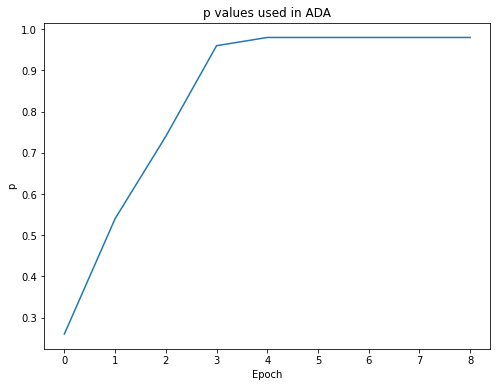

In [ ]:
import matplotlib.pyplot as plt
# plot real/fake for discriminator loss
plt.figure(figsize=(8,6))
plt.plot(prob_log[:])
plt.title('p values used in ADA')
plt.ylabel('p')
plt.xlabel('Epoch')
plt.savefig("p_values.png")
plt.show()

## Spectral Normalization GAN
- run code cells in AC-GAN for helper functions
- only define generator, discriminator and GAN here

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 13.7MB/s 


In [ ]:
# use TFA spectral norm
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization

In [ ]:
# working up from just conv - using spectral normalization
def define_discriminator_SNGAN(in_shape=(64,64,3), lr=0.0002, beta_1=0.5, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = SpectralNormalization(Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 16x16
	fe = SpectralNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 8x8
	fe = SpectralNormalization(Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model(in_image, out1, name='SN-Discriminator_3x3_kernel')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# working up from just conv - using spectral normalization
def define_discriminator_SNGAN_32x32(in_shape=(32,32,3), lr=0.0002, beta_1=0.5, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 16x16
	fe = SpectralNormalization(Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 8x8
	fe = SpectralNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 4x4
	fe = SpectralNormalization(Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model(in_image, out1, name='SN-Discriminator_3x3_kernel_32x32')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# 3x3 - working up from just conv - using spectral normalization
def define_generator_SNGAN(latent_dim=100):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)

    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(3, (2,2), padding='same', kernel_initializer=init))(gen)
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model(in_lat, out_layer, name='SN-Generator_2x2_kernel')
    return model

In [ ]:
dim = 4 # channels/k where k = 8: from SA-GAN paper

# SN with self attention layer
def define_generator_SAGAN_debug(latent_dim=100):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)

    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(64, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # self attention layer
    print("Input shape at SA layer:", gen.shape)

    # f = Query
    f = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    print("Shape of the query after 1x1:", f.shape)
    f = K.permute_dimensions(f, (0, 2, 1, 3))
    print("Shape of the query after transpose:", f.shape)
    # flatten
    #f = Flatten()(f)
    f = Reshape(target_shape=(dim, 32*32))(f)
    print("Shape of the query after flatten", f.shape)

    # g = Key
    g = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    print("Shape of the key after 1x1", g.shape)
    # flatten the 32x32
    g = Reshape(target_shape=(32*32, dim))(g)
    #g = Reshape(target_shape=(g.shape[0], -1, g.shape[-1]))(g)
    #g = tf.reshape(g, shape=[g.shape[0], -1, g.shape[-1]])
    print("Shape of the key after flatten", g.shape)

    # a = attention before softmax
    a = tf.matmul(g,f)
    print("Shape of the matrix multiplication: key x query (should this be query x key?):", a.shape)

    # a_map = attention map
    a_map = Softmax()(a)
    print("Shape of attention map after softmax:", a_map.shape)
    #a_map = Reshape(target_shape=())(a_map)

    # h = Value
    h = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    print("Shape of the value after 1x1", h.shape)
    h = Reshape(target_shape=(dim, 32*32))(h)
    print("Shape of the value after flatten", h.shape)

    # o = output
    #a_map = K.permute_dimensions(a_map, (0, 2, 1))
    #print("Shape after transposing the attention map:", a_map.shape)
    print("Not taking the transpose of the attention map")

    o = tf.matmul(h, a_map)
    print("Shape of o = h x attention map:", o.shape)
    o = Reshape(target_shape=(32, 32, dim))(o)
    print("Shape of o after converting back to 32x32:", o.shape)
    # apply another convolution to attention map x h
    o = Conv2D(32, (1,1), kernel_initializer=init)(o)
    print("Shape of o after 1x1:", o.shape)

    # gen was original input
    #gamma = tf.Variable(initial_value=0, dtype=tf.float32)
    #self_attention = gamma * o + gen # adding back the input feature map to learned scale of self attention module
    #print("Shape of self attention layer:", self_attention.shape)

    # append to original input
    self_attention = Concatenate()([o, gen])
    print("Self attention layer appended with original:", self_attention.shape)

    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(self_attention)
    gen = SpectralNormalization(Conv2D(16, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    gen = SpectralNormalization(Conv2D(3, (2,2), padding='same', kernel_initializer=init))(gen)
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model(in_lat, out_layer, name='SAGAN-Generator_extra_16x16_dim_8')
    return model

In [ ]:
g = define_generator_SAGAN_debug()
#g = define_generator_SAGAN()
#d = define_discriminator_SNGAN()

Input shape at SA layer: (None, 32, 32, 32)
Shape of the query after 1x1: (None, 32, 32, 4)
Shape of the query after transpose: (None, 32, 32, 4)
Shape of the query after flatten (None, 4, 1024)
Shape of the key after 1x1 (None, 32, 32, 4)
Shape of the key after flatten (None, 1024, 4)
Shape of the matrix multiplication: key x query (should this be query x key?): (None, 1024, 1024)
Shape of attention map after softmax: (None, 1024, 1024)
Shape of the value after 1x1 (None, 32, 32, 4)
Shape of the value after flatten (None, 4, 1024)
Not taking the transpose of the attention map
Shape of o = h x attention map: (None, 4, 1024)
Shape of o after converting back to 32x32: (None, 32, 32, 4)
Shape of o after 1x1: (None, 32, 32, 32)
Self attention layer appended with original: (None, 32, 32, 64)


In [ ]:
dim = 8 # channels/k where k = 8: from SA-GAN paper

# SN with self attention layer
def define_generator_SAGAN(latent_dim=100):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image generator input
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((8, 8, 128))(gen)

    # upsample to 16x16
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(64, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # upsample to 32x32
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(gen)
    gen = SpectralNormalization(Conv2D(32, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    # self attention layer

    # f = Query
    f = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    f = K.permute_dimensions(f, (0, 2, 1, 3))
    # flatten
    #f = Flatten()(f)
    f = Reshape(target_shape=(dim, 32*32))(f)

    # g = Key
    g = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    # flatten the 32x32
    g = Reshape(target_shape=(32*32, dim))(g)
    #g = Reshape(target_shape=(g.shape[0], -1, g.shape[-1]))(g)
    #g = tf.reshape(g, shape=[g.shape[0], -1, g.shape[-1]])

    # a = attention before softmax
    a = tf.matmul(g,f)

    # a_map = attention map
    a_map = Softmax()(a)
    #a_map = Reshape(target_shape=())(a_map)

    # h = Value
    h = Conv2D(dim, (1,1), kernel_initializer=init)(gen)
    h = Reshape(target_shape=(dim, 32*32))(h)

    # o = output
    #a_map = K.permute_dimensions(a_map, (0, 2, 1))
    #print("Shape after transposing the attention map:", a_map.shape)

    o = tf.matmul(h, a_map)
    o = Reshape(target_shape=(32, 32, dim))(o)
    # apply another convolution to attention map x h
    o = Conv2D(32, (1,1), kernel_initializer=init)(o)

    # append to original input
    self_attention = Concatenate()([o, gen])

    # upsample to 64x64
    gen = UpSampling2D(size=(2,2), interpolation='nearest')(self_attention)
    gen = SpectralNormalization(Conv2D(16, (2,2), padding='same', kernel_initializer=init))(gen)
    gen = Activation('relu')(gen)

    gen = SpectralNormalization(Conv2D(3, (2,2), padding='same', kernel_initializer=init))(gen)
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model(in_lat, out_layer, name='SAGAN-Generator_extra_16x16_dim_8')
    return model

In [ ]:
g.summary()

Model: "SAGAN-Generator_extra_16x16_dim_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8192)         827392      input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 8192)         0           dense[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 8, 8, 128)    0           activation[0][0]                 
__________________________________________________________________

# AC-GAN v2
- output per class on a row
- add Alex's nearest neighbor code
- SN linear?

## Imports + Setup

In [89]:
from math import sqrt
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from numpy.random import random
from numpy.random import choice
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Softmax
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from matplotlib import pyplot
from IPython import display

## Load Dataset
- only Flowers dataset modified for OHE labels
- set NUM_CLASSES here

In [ ]:
# load image data
flip = False
x, y = load_image_net_data(scale=True, flip=flip)

print("Restricting to", NUM_CLASSES, "classes")
IMG_PER_CLASS = 900

if flip:
    x = x[0:IMG_PER_CLASS * NUM_CLASSES * 2]
    y = y[0:IMG_PER_CLASS * NUM_CLASSES * 2]
else:
    x = x[0:IMG_PER_CLASS * NUM_CLASSES]
    y = y[0:IMG_PER_CLASS * NUM_CLASSES]
print(x.shape)
print(y.shape)
dataset = [x, y]

NUM_CLASSES = max(y) - min(y) + 1
print("NUM_CLASSES =", NUM_CLASSES)

shape of the data: (40, 900, 12288)
classes: 40
images per class: 900
pixel values in images: 12288
shape after removing classes: (36000, 12288)
Converting data shape to 2D with 3 channels
scaling values to the range [-1, 1]
formatted shape: (36000, 64, 64, 3)
Restricting to 5 classes
(4500, 64, 64, 3)
(4500,)
NUM_CLASSES = 5


(60000, 32, 32, 3)
(60000, 1)
scaling values to the range [-1, 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images: (60000, 32, 32, 3)
labels: (60000, 1)
min label: 0
max label: 9


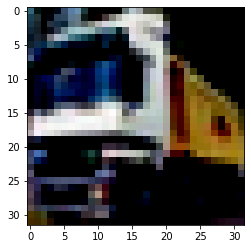

In [ ]:
# load cifar10 data
x, y = load_cifar10_data(scale=True)

images = []
labels = []

NUM_CLASSES = 10

# restricting to NUM_CLASSES
for i in range(len(y)):
    if y[i] in range(NUM_CLASSES):
        images.append(x[i])
        labels.append(y[i])

images = np.asarray(images)
labels = np.asarray(labels)

print("images:", images.shape)
print("labels:", labels.shape)
print("min label:", np.min(labels))
print("max label:", np.max(labels))

dataset = [images, labels]

plt.imshow(images[1])

In [ ]:
# load birds dataset 32x32
images, labels = load_birds_data_direct(scale=True, target_shape=(32,32))
dataset = [images, labels]
plt.imshow(images[0])
print("image label:", labels[0])

NUM_CLASSES = max(labels) - min(labels) + 1
print("NUM_CLASSES =", NUM_CLASSES)

Loading Flowers dataset
Target Shape: (64, 64)
Found 3670 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


scaling values to the range [-1, 1]
images: (3670, 64, 64, 3)
labels: (3670, 5)
Showing 1 image (discolored due to tanh scaling)
NUM_CLASSES = 5


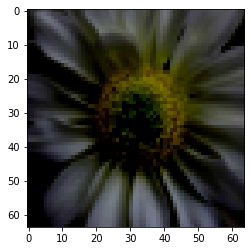

In [90]:
# load flowers dataset
images, labels = load_flowers_data(scale=True, target_shape=(64,64), one_hot=True, interp='bilinear') # changed to one_hot labels

print("images:", images.shape)
print("labels:", labels.shape)
print("Showing 1 image (discolored due to tanh scaling)")
plt.imshow(images[0])
dataset = [images, labels]


NUM_CLASSES = 5
print("NUM_CLASSES =", NUM_CLASSES)

### Validation Set Testing
Change if you want to withhold some data for use as a validation set
(only recommended for testing overfitting)

Default is validation flag = False

**Warning: only execute this code once or you will repeatedly reduce the dataset size**

In [91]:
VALIDATION_SET = True

In [ ]:
VALIDATION_SET = False

In [92]:
if VALIDATION_SET:
    # segment out 10% of the data and rename it
    images, labels = dataset
    image_count = len(images) # len of labels
    print("Found", image_count, "images in the dataset")
    val_count = image_count // 10 # 10% of the images are saved for validation set
    print("Removing", val_count, "images for validation set ")

    val_images = images[:val_count]
    val_labels = labels[:val_count]
    print("val_images.shape:", val_images.shape)

    images = images[val_count:]
    labels = labels[val_count:]
    print("images.shape:", images.shape)

    dataset = [images, labels]

Found 3670 images in the dataset
Removing 367 images for validation set 
val_images.shape: (367, 64, 64, 3)
images.shape: (3303, 64, 64, 3)


In [ ]:
# check that validation set is correct 10% of the dataset
#val_count = len(val_images)
#train_count = len(dataset[0])
#total_count = val_count + train_count
#
#expected_val_count = total_count // 10
#if expected_val_count != val_count:
#    NUM_CLASSES = -1 # essentially raise an error
#    print("ERROR MISMATCH IN VALIDATION SET SIZE")
#
#else:
#    print("Validation set size correct!\nGood luck with your experiment!")

### Show some images from each class

In [93]:
def show_dataset(dataset, num_classes=10, images_per_class=10):
    '''
    given the number of classes and images to show per class,
    show that many images, in a row, per class
    pass images to show_samples() w n_rows = num_classes and n_cols = images_per_class
    '''
    print("Showing some images from the dataset\nNUM_CLASSES =", num_classes)
    images_found_count = 0
    current_label = 0

    # find images_per_class number of images per class and append them to a list
    sorted_images = []
    images, labels = dataset
    # find images per class
    while current_label < num_classes:
        #print("Finding", images_per_class, "images of class", current_label)
        i = 0
        # find 10 images in this class
        while images_found_count < images_per_class:
            if labels[i] == current_label:
                sorted_images.append(images[i])
                images_found_count += 1
            i += 1
        images_found_count = 0
        current_label += 1

    # sort and convert to int
    sorted_images = np.asarray(sorted_images)
    sorted_images = ((sorted_images + 1)/2.0*255).astype(int) 

    # plot the result
    f, axs = plt.subplots(num_classes, images_per_class, figsize=(16,16))
    plt.subplots_adjust(hspace=-0.85, wspace=0.07)
    # plot images
    for i in range(num_classes*images_per_class):
       axs[i//images_per_class, i%images_per_class].imshow(sorted_images[i])
       axs[i//images_per_class, i%images_per_class].axis("off")

In [94]:
show_dataset(dataset, num_classes=NUM_CLASSES, images_per_class=20)

Showing some images from the dataset
NUM_CLASSES = 5


ValueError: ignored

## Discriminator Models

In [ ]:
# AC-GAN discriminator
def define_discriminator_ACGAN(in_shape=(64,64,3), n_classes=10, lr=0.0002, beta_1=0.5, beta_2=0.999):
    # random kernel initial weights
    init = RandomNormal(stddev=0.02)
    # real/fake image input
    img_input = Input(shape=in_shape)

    # normal + downsample alternate to 8x8

    # norm @ 64x64
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(img_input)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample @ 64x64 -> 32x32
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    # norm @ 32x32
    fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample @ 32x32 -> 16x16
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    # norm @ 16x16
    fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample @ 16x16 -> 8x8
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    fe = Flatten()(fe)

    # outputs
    # real/fake output
    real_fake_output = Dense(1, activation='sigmoid')(fe)
    # class label output
    class_label_output = Dense(n_classes, activation='softmax')(fe)

    # define model
    model = Model(img_input, [real_fake_output, class_label_output], name='AC_GAN_Discriminator_v2_BN_and_Dropout')
    # compile model
    opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model


In [ ]:
def define_discriminator_ACGAN(in_shape=(64,64,3), n_classes=10, lr=0.0002, beta_1=0.5, beta_2=0.999):
    # random kernel initial weights
    init = RandomNormal(stddev=0.02)
    # real/fake image input
    img_input = Input(shape=in_shape)

    # downsample @ 64x64 -> 32x32
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(img_input)
    fe = LeakyReLU(alpha=0.2)(fe)

    # downsample @ 32x32 -> 16x16
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # downsample @ 16x16 -> 8x8
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Flatten()(fe)

    # outputs
    # real/fake output
    real_fake_output = Dense(1, activation='sigmoid')(fe)
    # class label output
    class_label_output = Dense(n_classes, activation='softmax')(fe)

    # define model
    model = Model(img_input, [real_fake_output, class_label_output], name='AC_GAN_Discriminator_v0_wo_normal_before_downsample')
    # compile model
    opt = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model


In [113]:
# OHE
def define_discriminator_ACGAN(in_shape=(64,64,3), n_classes=10, lr=0.0002, beta_1=0.5, beta_2=0.999):
    # random kernel initial weights
    init = RandomNormal(stddev=0.02)
    # real/fake image input
    img_input = Input(shape=in_shape)

    # norm @ 64x64
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(img_input)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample @ 64x64 -> 32x32
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # norm @ 32x32
    fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample @ 32x32 -> 16x16
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # norm @ 16x16
    fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample @ 16x16 -> 8x8
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # norm @ 8x8
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample @ 8x8 -> 4x4
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    fe = Flatten()(fe)

    # outputs
    # real/fake output
    real_fake_output = Dense(1, activation='sigmoid')(fe)
    # class label output
    class_label_output = Dense(n_classes, activation='softmax')(fe)

    # define model
    model = Model(img_input, [real_fake_output, class_label_output], name='AC_GAN_Discriminator_OHE_v1_downsample_to_4x4')
    # compile model
    opt = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

### Spectral Normalization

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 4.1MB/s 


In [ ]:
# use TFA spectral norm
import tensorflow_addons as tfa
from tensorflow_addons.layers import SpectralNormalization

In [ ]:
# SN example
# working up from just conv - using spectral normalization
def define_discriminator_SNGAN(in_shape=(64,64,3), lr=0.0002, beta_1=0.5, beta_2=0.999):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 32x32
	fe = SpectralNormalization(Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 16x16
	fe = SpectralNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample to 8x8
	fe = SpectralNormalization(Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model(in_image, out1, name='SN-Discriminator_3x3_kernel')
	# compile model
	opt = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# AC-GAN discriminator - no BN and Dropout
def define_discriminator_SN_ACGAN(in_shape=(64,64,3), n_classes=10, lr=0.0002, beta_1=0.5, beta_2=0.999):
    # random kernel initial weights
    init = RandomNormal(stddev=0.02)
    # real/fake image input
    img_input = Input(shape=in_shape)

    # normal + downsample alternate to 8x8

    # norm @ 64x64
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(img_input)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample @ 64x64 -> 32x32
    fe = SpectralNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # norm @ 32x32
    fe = SpectralNormalization(Conv2D(128, (3,3), padding='same', kernel_initializer=init))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample @ 32x32 -> 16x16
    fe = SpectralNormalization(Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # norm @ 16x16
    fe = SpectralNormalization(Conv2D(128, (3,3), padding='same', kernel_initializer=init))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample @ 16x16 -> 8x8
    fe = SpectralNormalization(Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Dropout(0.5)(fe)
    fe = Flatten()(fe)

    # outputs
    # real/fake output
    real_fake_output = Dense(1, activation='sigmoid')(fe)
    # class label output
    class_label_output = Dense(n_classes, activation='softmax')(fe)

    # define model
    model = Model(img_input, [real_fake_output, class_label_output], name='AC_GAN_Discriminator_v2_no_SN_on_input')
    # compile model
    opt = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

## Generator Models

In [ ]:
def define_generator_ACGAN(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)

    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 8*8*1
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((8, 8, 1))(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 8x8 image
    n_nodes = 8*8*255
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 255))(gen)

    # combine the 2 inputs
    merge = Concatenate()([gen, li])

    # upsample to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 64x64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # output layer
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer, name='AC_GAN_Generator_v2_1_ch_label')
    return model

In [96]:
# OHE
def define_generator_ACGAN(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)

    # label input
    in_label = Input(shape=(n_classes,))
    # embedding for categorical input
    n_nodes = 4*4*4
    li = Dense(n_nodes, kernel_initializer=init)(in_label)
    # reshape to additional channel
    li = Reshape((4, 4, 4))(li) # kept number of n_nodes @ 64; this is going to have to be more for EEG latent vector of length 100

    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 8x8 image
    n_nodes = 4*4*252 
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 252))(gen) # wanted to keep it @ total channels = 256

    # combine the 2 inputs
    merge = Concatenate()([gen, li])

    # upsample to 8x8
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 64x64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # output layer
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer, name='AC_GAN_Generator_OHE_v1_upsample_from_4x4')
    return model

## Helper Functions

### Inception Score

In [97]:
# inception score
# helper function called during training to return inception score
# calculate inception score for cifar-10 in Keras
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

def get_inception_score(generator):
    # generate 10,000 images to run inception score on
    [images, _], _ = generate_fake_samples(generator, latent_dim, 1000)

    images = (images + 1) / 2.0
    images = images * 255

    is_avg, is_std = calculate_inception_score(images)
    print('IS score (avg, std)', is_avg, is_std)
    return is_avg, is_std

### FID

In [98]:
# FID
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets.mnist import load_data
from skimage.transform import resize

# prepare the inception v3 model
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with bicubic interpolation
        new_image = resize(image, new_shape, 3) # switched from 0 (nearest neighbor) to 3 (bicubic)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# calculate frechet inception distance
def _calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_fid(real_images, fake_images):
    r = real_images.astype("float32")
    r = scale_images(r, (299,299,3))
    r = preprocess_input(r)

    f = fake_images.astype("float32")
    f = scale_images(f, (299,299,3))
    f = preprocess_input(f)
    
    fid = _calculate_fid(fid_model, r, f)
    return fid

87916544/87910968 [==============================] - 0s 0us/step


In [99]:
def get_fid(generator, latent_dim=100, test_image_count = 1000):
    [fake_samples, _], _ = generate_fake_samples(generator, latent_dim, test_image_count) 
    # need to handle for if test_image_count > dataset
    if dataset[0].shape[0] < test_image_count:
        test_image_count = dataset[0].shape[0]
    [real_samples, _], _ = generate_real_samples(dataset, test_image_count)  

    real_samples = ((real_samples + 1)/2.0*255).astype(int) 
    fake_samples = ((fake_samples + 1)/2.0*255).astype(int)  

    fid = calculate_fid(real_images=real_samples, fake_images=fake_samples)

    print("FID:", fid)
    return fid

### Train Model Helper Functions

In [100]:
# show a plot of generated images
def save_plot(examples, n_examples, file_name, fig_size=10):
    plt.figure(figsize=(fig_size, fig_size))
    # plot images
    for i in range(n_examples):
        # define subplot
        plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    plt.savefig(file_name+'.png')
    plt.show()

In [101]:
def model_info(model, name):
    model.summary()
    plot_model(model, to_file=name+'.png', show_shapes=True, show_layer_names=True)

In [102]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    #ix = randint(0, images.shape[0], n_samples)
    # get permutations instead of random (could have duplicates)
    ix = np.random.permutation(images.shape[0])[0:n_samples]
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=NUM_CLASSES):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    x = np.eye(n_classes) # identity matrix
    labels = x[np.random.choice(n_classes, size=n_samples)] # take random choices from the identity matrix
    labels = np.asarray(labels)

    return [z_input, labels]

In [104]:
# OHE label code
seed_labels = []
IMAGES_PER_CLASS = 20 # save 20 images per class when generating seeded images
for i in range(NUM_CLASSES):
    seed_labels.append(np.repeat(i, IMAGES_PER_CLASS))
seed_labels = np.asarray(seed_labels)
seed_labels = seed_labels.flatten()

# switch to OHE
seed_labels = to_categorical(seed_labels)

# seed for generating the images from the same latent space
seed_latent, _ = generate_latent_points(100, IMAGES_PER_CLASS*NUM_CLASSES, NUM_CLASSES)

In [105]:
print(seed_labels)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1.

In [106]:
def show_prediction():
    images = generator.predict([seed_latent, seed_labels])
    images = ((images + 1)/2.0*255).astype(int) 
    images_per_class = 20
    # plot the result
    f, axs = plt.subplots(NUM_CLASSES, images_per_class, figsize=(16,16))
    plt.subplots_adjust(hspace=-0.85, wspace=0.07)
    # plot images
    for i in range(NUM_CLASSES*images_per_class):
        axs[i//images_per_class, i%images_per_class].imshow(images[i])
        axs[i//images_per_class, i%images_per_class].axis("off")

### Label Smoothing + Noisy Labels
- not updated for OHE

In [107]:
# example of positive label smoothing
# example of smoothing class=1 to [0.7, 1.2]
def smooth_positive_labels(y):
	return y - 0.3 + (random(y.shape) * 0.5)
 
# example of smoothing class=0 to [0.0, 0.3]
def smooth_negative_labels(y):
	return y + random(y.shape) * 0.3

In [ ]:
# generate 'real' class labels (1)
n_samples = 1000
y = ones((n_samples, 1))
# smooth labels
y = smooth_positive_labels(y)
# summarize smooth labels
print("smooth labels close to 1:", y.shape, y.min(), y.max())

# generate 'fake' class labels (0)
y = zeros((n_samples, 1))
# smooth labels
y = smooth_negative_labels(y)
# summarize smooth labels
print("smooth labels close to 0:", y.shape, y.min(), y.max())

In [ ]:
# randomly flip some labels
def noisy_labels(y, p_flip):
	# determine the number of labels to flip
	n_select = int(p_flip * y.shape[0])
	# choose labels to flip
	flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y

In [ ]:
# generate 'real' class labels (1)
n_samples = 1000
y = ones((n_samples, 1))
# flip labels with 5% probability
y = noisy_labels(y, 0.05)
# summarize labels
print(y.sum())
 
# generate 'fake' class labels (0)
y = zeros((n_samples, 1))
# flip labels with 5% probability
y = noisy_labels(y, 0.05)
# summarize labels
print(y.sum())

### Train Functions

In [108]:
# generate samples and save as a plot and save the model
def summarize_performance(epoch, g_model, latent_dim, bat_per_epo=140, n_samples=100):
    # create fake samples
    images = g_model.predict([seed_latent, seed_labels])
    images = ((images + 1)/2.0*255).astype(int) 
    
    # plot the fake samples = NUM_PER_CLASS
    NUM_PER_CLASS = 20
    f, axs = plt.subplots(NUM_CLASSES, NUM_PER_CLASS, figsize=(16,16))
    plt.subplots_adjust(hspace=-0.85, wspace=0.07)
    # plot images
    for i in range(NUM_CLASSES*NUM_PER_CLASS):
       axs[i//NUM_PER_CLASS, i%NUM_PER_CLASS].imshow(images[i])
       axs[i//NUM_PER_CLASS, i%NUM_PER_CLASS].axis("off")

    display.clear_output(wait=True)

    filename1 = 'seeded_images_ep_%04d.png' % (epoch)
    plt.savefig(filename1)
    plt.show()
    plt.close()

    # save the generator model
    filename2 = 'model_%04d.h5' % (epoch)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [109]:
# function that takes in 3 lists of (1,3) tuples and returns 3 (1,3) tuples of average loss across the  epoch
def avg_loss_per_epo(d_real_losses, d_fake_losses, g_losses, bat_per_epo):
    d_r_sums = [0, 0, 0]
    d_f_sums = [0, 0, 0]
    g_sums = [0, 0, 0]
    # sum the losses per batch
    for total_loss, r_f_loss, class_loss in d_real_losses:
        d_r_sums[0] += total_loss
        d_r_sums[1] += r_f_loss
        d_r_sums[2] += class_loss
    # averaged the losses over the epoch
    for i in range(len(d_r_sums)):
        d_r_sums[i] /= bat_per_epo

    # sum the losses per batch
    for total_loss, r_f_loss, class_loss in d_fake_losses:
        d_f_sums[0] += total_loss
        d_f_sums[1] += r_f_loss
        d_f_sums[2] += class_loss
    # averaged the losses over the epoch
    for i in range(len(d_r_sums)):
        d_f_sums[i] /= bat_per_epo

    # sum the losses per batch
    for total_loss, r_f_loss, class_loss in g_losses:
        g_sums[0] += total_loss
        g_sums[1] += r_f_loss
        g_sums[2] += class_loss
    # averaged the losses over the epoch
    for i in range(len(d_r_sums)):
        g_sums[i] /= bat_per_epo
    return d_r_sums, d_f_sums, g_sums

In [110]:
# define the combined generator and discriminator model, for updating the generator
def define_AC_GAN(g_model, d_model, lr=0.0002, beta_1=0.5, beta_2=0.999):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output, name="Combined_AC_GAN")
	# compile model
	opt = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2)
	model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
	return model

# generate n fake images with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# compute accuracies on real, generated, and validation images
# return tuple of accuracies for each set of images
def compute_accuracies(g_model, d_model, dataset, latent_dim):
    # ############################# REAL IMAGES #############################
    [real_images, real_y], real_labels = generate_real_samples(dataset, len(val_images)) # generate same number of real samples as validation samples
    # make predictions on real set
    y_pred, labels_pred = d_model.predict(real_images)
    # count true predictions
    true_count = 0
    for pred in y_pred:
        if pred > 0.5:
            true_count += 1
    print("Real image set predicted 1's:", true_count, "/", len(labels_pred))

    # calculate and append accuracy
    real_y_acc = true_count / len(labels_pred)
    real_y_acc = round(real_y_acc, 2)
    print("Real image: real/fake accuracy:", real_y_acc)

    # append accuracy of labels_pred
    correct_count = 0
    for i, label in enumerate(labels_pred):
        # label is a vector of len NUM_CLASSES
        label = np.argmax(label)
        if label == np.argmax(real_labels[i]):
            correct_count += 1
    real_label_acc = correct_count / len(labels_pred)
    real_label_acc = round(real_label_acc, 2)
    print("Real: labels correct:", correct_count, "/", len(labels_pred))
    print("Real images label accuracy:", real_label_acc)

    # ############################# GENERATED IMAGES #############################
    [fake_images, fake_y], fake_labels = generate_fake_samples(g_model, latent_dim, len(val_images)) # generate same number of fake samples as validation samples
    # make predictions on fake set
    y_pred, labels_pred = d_model.predict(fake_images)
    # count fake predictions
    fake_count = 0
    for pred in y_pred:
        if pred <= 0.5: # true label for generated images is 0
            fake_count += 1
    print("Generated set predicted 0's:", fake_count, "/", len(labels_pred))

    # calculate and append accuracy
    fake_y_acc = fake_count / len(labels_pred)
    fake_y_acc = round(fake_y_acc, 2)
    print("Generated image: real/fake accuracy:", fake_y_acc)

    # append accuracy of labels_pred
    correct_count = 0
    for i, label in enumerate(labels_pred):
        # label is a vector of len NUM_CLASSES
        label = np.argmax(label)
        if label == np.argmax(fake_labels[i]):
            correct_count += 1
    fake_label_acc = correct_count / len(labels_pred)
    fake_label_acc = round(fake_label_acc, 2)
    print("Generated: labels correct:", correct_count, "/", len(labels_pred))
    print("Generated images label accuracy:", fake_label_acc)

    # ############################# VALIDATION IMAGES #############################
    # make predictions on validation set
    y_pred, labels_pred = d_model.predict(val_images)
    # count true predictions
    true_count = 0
    for pred in y_pred:
        if pred > 0.5:
            true_count += 1
    print("Validation set predicted 1's:", true_count, "/", len(labels_pred))

    # calculate and append accuracy
    val_y_acc = true_count / len(labels_pred)
    val_y_acc = round(val_y_acc, 2)
    print("Validation real/fake accuracy:", val_y_acc)

    # append accuracy of labels_pred
    correct_count = 0
    for i, label in enumerate(labels_pred):
        # label is a vector of len NUM_CLASSES
        label = np.argmax(label)
        if label == np.argmax(val_labels[i]):
            correct_count += 1
    val_label_acc = correct_count / len(labels_pred)
    val_label_acc = round(val_label_acc, 2)
    print("Validation: labels correct:", correct_count, "/", len(labels_pred))
    print("Validation images label accuracy:", val_label_acc)

    return real_y_acc, real_label_acc, fake_y_acc, fake_label_acc, val_y_acc, val_label_acc

# train function 
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)

    # loss per batch used for averaging across epoch
    d_rs, d_fs, gs = [], [], [] 

    # averaged losses per epoch
    d_rs_epo, d_fs_epo, gs_epo = [], [], []

    # Accuracies across real, gen, val images
    real_y_accs, real_label_accs, fake_y_accs, fake_label_accs, val_y_accs, val_label_accs = [], [], [], [], [], []

    # image quality scores
    is_scores, fid_scores = [], []

    # manually enumerate epochs
    for i in range(n_steps):
        if i % bat_per_epo == 0 and i > 0:
            print("\nEpoch", int(i/bat_per_epo))
            d_r_avgs, d_f_avgs, g_avgs = avg_loss_per_epo(d_rs, d_fs, gs, bat_per_epo)
            print("Discriminator real images total loss: %.3f, real/fake loss: %.3f, classification loss: %.3f" % (d_r_avgs[0], d_r_avgs[1], d_r_avgs[2]))
            print("Discriminator fake images total loss: %.3f, real/fake loss: %.3f, classification loss: %.3f" % (d_f_avgs[0], d_f_avgs[1], d_f_avgs[2]))
            print("Generator (fake images) total loss: %.3f, real/fake loss: %.3f, classification loss: %.3f" % (g_avgs[0], g_avgs[1], g_avgs[2]))

            d_rs_epo.append( d_r_avgs ) # average disciminator loss on real samples
            d_fs_epo.append( d_f_avgs ) # average disciminator loss on fake samples
            gs_epo.append( g_avgs) # average generator loss on real samples
            
            # reset the step specific losses
            d_rs, d_fs, gs = [], [], []

            if VALIDATION_SET:
                real_y_acc, real_label_acc, fake_y_acc, fake_label_acc, val_y_acc, val_label_acc = compute_accuracies(g_model, d_model, dataset, latent_dim)

                real_y_accs.append(real_y_acc)
                fake_y_accs.append(fake_y_acc)
                val_y_accs.append(val_y_acc)

                real_label_accs.append(real_label_acc)
                fake_label_accs.append(fake_label_acc)
                val_label_accs.append(val_label_acc)

        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        d_r0,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])

        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        d_f0,d_f1,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])

        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_0,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])

        # summarize loss on this batch
        d_rs.append((d_r0, d_r1, d_r2))
        d_fs.append((d_f0, d_f1, d_f2))
        gs.append((g_0, g_1, g_2))

        # summarize the model performance every 50 'epoch'
        if (i+1) % (bat_per_epo * 50) == 0:
            summarize_performance((i+1) / bat_per_epo, g_model, latent_dim)
        
        # calculate FID and IS every 20 'epoch'
        if (i+1) % (bat_per_epo * 20) == 0:
            # add inception scores
            score, std = get_inception_score(g_model)
            is_scores.append(score)

            # add FID scores
            fid = get_fid(g_model, latent_dim, test_image_count=1000)
            fid_scores.append(fid)
            
    # convert to numpy arrays
    d_rs_epo = np.asarray(d_rs_epo)
    d_fs_epo = np.asarray(d_fs_epo)
    gs_epo = np.asarray(gs_epo)
    is_scores = np.asarray(is_scores)
    fid_scores = np.asarray(fid_scores)

    real_y_accs = np.asarray(real_y_accs)
    fake_y_accs = np.asarray(fake_y_accs)
    val_y_accs = np.asarray(val_y_accs)

    real_label_accs = np.asarray(real_label_accs)
    fake_label_accs = np.asarray(fake_label_accs)
    val_label_accs = np.asarray(val_label_accs)

    # at the very end, compute FID using 50k images
    fid = get_fid(g_model, latent_dim, test_image_count=50000)
    print("Final FID for 50k images:", fid)

    return [d_rs_epo, d_fs_epo, gs_epo, is_scores, fid_scores, [real_y_accs, real_label_accs, fake_y_accs, fake_label_accs, val_y_accs, val_label_accs]] 

## Define Hyper-parameters + Create Model

In [111]:
# Hyper Parameter Tuning
latent_dim = 100 # size of the latent space

# hyper parameters from SAGAN paper
#LR_D = 0.0004
#LR_G = 0.0001
#BETA_1_D = 0
#BETA_2_D = 0.9
#BETA_1_G = 0
#BETA_2_G = 0.9
#NUM_EPOCHS = 500
#BATCH_SIZE = 64

# default Adam parameters
# LR_D = 0.001
# LR_G = 0.001
# BETA_1_D = 0.9
# BETA_2_D = 0.999
# BETA_1_G = 0.9
# BETA_2_G = 0.999
# NUM_EPOCHS = 1000
# BATCH_SIZE = 64

# hyper parameters testing
LR_D = 0.0002
LR_G = 0.0002
BETA_1_D = 0.5
BETA_2_D = 0.999
BETA_1_G = 0.5
BETA_2_G = 0.999
BATCH_SIZE = 64
NUM_EPOCHS = 500

In [114]:
# AC GAN
print("AC GAN for 64x64 images")
# create the discriminator
discriminator = define_discriminator_ACGAN(in_shape=(64,64,3), n_classes=NUM_CLASSES, lr=LR_D, beta_1=BETA_1_D, beta_2=BETA_2_D)
model_info(discriminator, "discriminator")
print()

# create the generator
generator = define_generator_ACGAN(latent_dim, n_classes=NUM_CLASSES)
model_info(generator, "generator")
print()

# create the gan
gan_model = define_AC_GAN(generator, discriminator, lr=LR_G, beta_1=BETA_1_G, beta_2=BETA_2_G)
model_info(gan_model, "AC_GAN_Model")

AC GAN for 64x64 images
Model: "AC_GAN_Discriminator_OHE_v1_downsample_to_4x4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 64, 64, 64)   1792        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 64, 64, 64)   0           conv2d_119[0][0]                 
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 32, 32, 128)  73856       leaky_re_lu_13[0][0]             
______________________________

## Train

In [115]:
print("Give a name to this experiment:")
experiment_name = input()

Give a name to this experiment:
ac_gan_flowers_64x64_ohe_norm_layers_4x4_3.7m_param


In [116]:
print("Hyper parameters for run:", experiment_name)
print('Dataset used:')
print('LR_D =', LR_D)
print('LR_G =', LR_G)
print('BETA_1_D =', BETA_1_D)
print('BETA_2_D =', BETA_2_D)
print('BETA_1_G =', BETA_1_G)
print('BETA_2_G =', BETA_2_G)
print('BATCH_SIZE =', BATCH_SIZE)
print('NUM_EPOCHS =', NUM_EPOCHS)
print('NUM_CLASSES =', NUM_CLASSES)
print('LATENT_DIM =', latent_dim)
print("VALIDATION_SET FLAG =", VALIDATION_SET)

Hyper parameters for run: ac_gan_flowers_64x64_ohe_norm_layers_4x4_3.7m_param
Dataset used:
LR_D = 0.0002
LR_G = 0.0002
BETA_1_D = 0.5
BETA_2_D = 0.999
BETA_1_G = 0.5
BETA_2_G = 0.999
BATCH_SIZE = 64
NUM_EPOCHS = 500
NUM_CLASSES = 5
LATENT_DIM = 100
VALIDATION_SET FLAG = True


In [ ]:
# train model
d_r_ep, d_f_ep, g_ep, is_scores, fid_scores, accuracies = train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=NUM_EPOCHS, n_batch=BATCH_SIZE)


Epoch 1
Discriminator real images total loss: 1.933, real/fake loss: 0.283, classification loss: 1.650
Discriminator fake images total loss: 2.006, real/fake loss: 0.382, classification loss: 1.624
Generator (fake images) total loss: 4.715, real/fake loss: 3.078, classification loss: 1.637
Real image set predicted 1's: 339 / 367
Real image: real/fake accuracy: 0.92
Real: labels correct: 0 / 367
Real images label accuracy: 0.0
Generated set predicted 0's: 367 / 367
Generated image: real/fake accuracy: 1.0
Generated: labels correct: 0 / 367
Generated images label accuracy: 0.0
Validation set predicted 1's: 326 / 367
Validation real/fake accuracy: 0.89
Validation: labels correct: 4 / 367
Validation images label accuracy: 0.01

Epoch 2
Discriminator real images total loss: 1.720, real/fake loss: 0.145, classification loss: 1.575
Discriminator fake images total loss: 1.763, real/fake loss: 0.138, classification loss: 1.625
Generator (fake images) total loss: 5.710, real/fake loss: 4.069, c

## Analysis

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(d_r_ep.shape)
print(d_f_ep.shape)
print(g_ep.shape)
print("IS Scores:", is_scores.shape)
print("FID Scores:", fid_scores.shape)

NameError: ignored

In [ ]:
real_y_accs, real_label_accs, fake_y_accs, fake_label_accs, val_y_accs, val_label_accs = accuracies
print(real_y_accs[:10])

In [ ]:
# plot all at once

if VALIDATION_SET:
    # create an extra row for validation accuracies
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 18))

    # combined real/fake loss
    axs[0, 0].set_title('Model Real/Fake Loss')
    axs[0, 0].plot(d_r_ep[:,1])
    axs[0, 0].plot(d_f_ep[:,1])
    axs[0, 0].plot(g_ep[:,1])
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper right')

    # combined classification loss
    axs[0, 1].set_title('Model Classificiation Loss')
    axs[0, 1].plot(d_r_ep[:,2])
    axs[0, 1].plot(d_f_ep[:,2])
    axs[0, 1].plot(g_ep[:,2])
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper right')

    # real/fake discriminator loss
    axs[1, 0].set_title("Discriminator Real/Fake Loss")
    axs[1, 0].plot(d_r_ep[:,1])
    axs[1, 0].plot(d_f_ep[:,1])
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].legend(['Discriminator Real', 'Discriminator Fake'], loc='upper right')

    # real/fake generator loss
    axs[1, 1].set_title("Generator Real/Fake Loss")
    axs[1, 1].plot(g_ep[:,1], color='g')
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")

    # validation real/fake accuracy
    axs[2,0].set_title('Real/Fake Accuracies')
    axs[2,0].plot(real_y_accs, color='b')
    axs[2,0].plot(fake_y_accs, color='r')
    axs[2,0].plot(val_y_accs,  color='g')
    axs[2,0].set_xlabel('Epoch')
    axs[2,0].set_ylabel('Accuracy')
    axs[2,0].legend(['Real', 'Generated', 'Validation'], loc='upper right')

    # validation class label accuracy
    axs[2,1].set_title('Class Label Accuracies')
    axs[2,1].plot(real_label_accs, color='b')
    axs[2,1].plot(fake_label_accs, color='r')
    axs[2,1].plot(val_label_accs, color='g')
    axs[2,1].set_xlabel('Epoch')
    axs[2,1].set_ylabel('Accuracy')
    axs[2,1].legend(['Real', 'Generated', 'Validation'], loc='upper right')

    # FID scores
    axs[3,0].set_title('FID Scores/100 Epochs')
    axs[3,0].plot(fid_scores[:], color='m')
    axs[3,0].set_xlabel('x10 Epoch')
    axs[3,0].set_ylabel('FID Score')

    # IS scores
    axs[3,1].set_title('Inception Scores/100 Epochs')
    axs[3,1].plot(is_scores[:], color='c')
    axs[3,1].set_xlabel('x10 Epoch')
    axs[3,1].set_ylabel('Inception Score')

    plt.savefig("Performance_Analysis.png")
    plt.show()

else: 
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))

    # combined real/fake loss
    axs[0, 0].set_title('Model Real/Fake Loss')
    axs[0, 0].plot(d_r_ep[:,1])
    axs[0, 0].plot(d_f_ep[:,1])
    axs[0, 0].plot(g_ep[:,1])
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper right')

    # combined classification loss
    axs[0, 1].set_title('Model Classificiation Loss')
    axs[0, 1].plot(d_r_ep[:,2])
    axs[0, 1].plot(d_f_ep[:,2])
    axs[0, 1].plot(g_ep[:,2])
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend(['Discriminator Real', 'Discriminator Fake', 'Generator'], loc='upper right')

    # real/fake discriminator loss
    axs[1, 0].set_title("Discriminator Real/Fake Loss")
    axs[1, 0].plot(d_r_ep[:,1])
    axs[1, 0].plot(d_f_ep[:,1])
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].legend(['Discriminator Real', 'Discriminator Fake'], loc='upper right')

    # real/fake generator loss
    axs[1, 1].set_title("Generator Real/Fake Loss")
    axs[1, 1].plot(g_ep[:,1], color='g')
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")

    # FID scores
    axs[2,0].set_title('FID Scores/100 Epochs')
    axs[2,0].plot(fid_scores[:], color='m')
    axs[2,0].set_xlabel('x10 Epoch')
    axs[2,0].set_ylabel('FID Score')

    # IS scores
    axs[2,1].set_title('Inception Scores/100 Epochs')
    axs[2,1].plot(is_scores[:], color='c')
    axs[2,1].set_xlabel('x10 Epoch')
    axs[2,1].set_ylabel('Inception Score')

    plt.savefig("Performance_Analysis.png")
    plt.show()

In [ ]:
# create 100 images
latent_dim = 100
n_examples = 100 # must be a square
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_classes=1)
# generate images
X  = generator.predict([latent_points, labels])
# scale from [-1,1] to [0,255]
X = ((X + 1)/2.0*255).astype(int) 
save_plot(X, n_examples, file_name='10x10_final_images', fig_size=20)

In [ ]:
# create 9 large images
latent_dim = 100
n_examples = 9# must be a square
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_classes=1)
# generate images
X  = generator.predict([latent_points, labels])
# scale from [-1,1] to [0,255]
X = ((X + 1)/2.0*255).astype(int) 
save_plot(X, n_examples, file_name='3x3_final_images')

In [ ]:
# create a gif with the seeded images
import imageio
import glob

anim_file = 'training_generated_images.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('seeded*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)

## Generate Directory + Save Results

In [ ]:
import datetime
dt = datetime.datetime.today()

In [ ]:
# Create a directory to save generated model/images to
gan_test_directory = './gdrive/MyDrive/EEG2Image/GAN/tests/'
print("Contents of", gan_test_directory)
!ls $gan_test_directory

print("\nDirectory:", experiment_name, "will be generated at the end of successful training and result analysis")

month_day_year = str(dt.month) + '_' + str(dt.day) + '_' + str(dt.year)
print("\nDate stamp:", month_day_year)

if len(experiment_name) == 0 or experiment_name is None:
    print("Error in given name...\nSetting temporary directory name.")
    experiment_name = 'temp_name'

directory_name = month_day_year + '_' + experiment_name

full_path = gan_test_directory + directory_name + '/'
print("\nMaking a directory at", full_path)
!mkdir $full_path

print("\nContents of", gan_test_directory, "after attempting to generate directory")
!ls $gan_test_directory

print("\nContents of", full_path)
!ls $full_path

In [ ]:
print("Copying generated images to", full_path, "\n")
!cp ./*.png $full_path
print("Copying generated gif", full_path, "\n")
!cp ./*.gif $full_path
print("Copying model artifacts to", full_path, "\n")
!cp ./*.h5 $full_path


print("\nContents of", full_path, "after copy attempt")
!ls $full_path

In [ ]:
# clean the current directory
print("Cleaning current working directory")
!rm ./*.png
!rm ./*.h5
#!rm ./*.gif